# Data cleaning using regular expresions 

We will be working with messy medical data and using regex to extract relevant infromation from the data. 

Each line of the `dates.txt` file corresponds to a medical note. Each note has a date that needs to be extracted, but each date is encoded in one of many formats.

The goal of this assignment is to correctly identify all of the different date variants encoded in this dataset and to properly normalize and sort the dates. 

Here is a list of some of the variants you might encounter in this dataset:
* 04/20/2009; 04/20/09; 4/20/09; 4/3/09
* Mar-20-2009; Mar 20, 2009; March 20, 2009;  Mar. 20, 2009; Mar 20 2009;
* 20 Mar 2009; 20 March 2009; 20 Mar. 2009; 20 March, 2009
* Mar 20th, 2009; Mar 21st, 2009; Mar 22nd, 2009
* Feb 2009; Sep 2009; Oct 2010
* 6/2008; 12/2009
* 2009; 2010

Once you have extracted these date patterns from the text, the next step is to sort them in ascending chronological order accoring to the following rules:
* Assume all dates in xx/xx/xx format are mm/dd/yy
* Assume all dates where year is encoded in only two digits are years from the 1900's (e.g. 1/5/89 is January 5th, 1989)
* If the day is missing (e.g. 9/2009), assume it is the first day of the month (e.g. September 1, 2009).
* If the month is missing (e.g. 2010), assume it is the first of January of that year (e.g. January 1, 2010).
* Watch out for potential typos as this is a raw, real-life derived dataset.

With these rules in mind, find the correct date in each note and return a pandas Series in chronological order of the original Series' indices. This Series should be sorted by a tie-break sort in the format of ("extracted date", "original row number").

For example if the original series was this:

    0    1999
    1    2010
    2    1978
    3    2015
    4    1985

Your function should return this:

    0    2
    1    4
    2    0
    3    1
    4    3


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

doc = []
with open('dates.txt') as file:
    for line in file:
        doc.append(line)

df = pd.Series(doc)
df.head(10)

0         03/25/93 Total time of visit (in minutes):\n
1                       6/18/85 Primary Care Doctor:\n
2    sshe plans to move as of 7/8/71 In-Home Servic...
3                7 on 9/27/75 Audit C Score Current:\n
4    2/6/96 sleep studyPain Treatment Pain Level (N...
5                    .Per 7/06/79 Movement D/O note:\n
6    4, 5/18/78 Patient's thoughts about current su...
7    10/24/89 CPT Code: 90801 - Psychiatric Diagnos...
8                         3/7/86 SOS-10 Total Score:\n
9             (4/10/71)Score-1Audit C Score Current:\n
dtype: object

In [34]:
month_abbr = {"Jan" : 1, "Feb" : 2, "Mar" : 3, "Apr" : 4,
             "May" : 5, "Jun" : 6, "Jul" : 7, "Aug" : 8,
             "Sep" : 9, "Oct" : 10, "Nov" : 11, "Dec" : 12}

def date_sorter(df):
    import re
    data = df.to_frame("Text")
    data["Length"] = df.str.len()
    days = []
    months = []
    years = []

    for id in list(range(len(data))) :
        text = data.iloc[id, 0]

        #0 - 124
        
        #Of type mm/dd/yyyy.
        if re.search(r'\d{1,2}[/-]\d{1,2}[/-]\d{4}', text) :
            date = (re.search(r'\d{1,2}[/-]\d{1,2}[/-]\d{4}', text)).group()
            md = int(date.find(r'/'))
            dy = int(date.rfind(r'/'))
            day = int(date[md + 1 : dy])
            month = int(date[0 : md])
            year = int(date[-4 :])
            
        #Of type (m)m/(d)d/yy.
        elif re.search(r'\d{1,2}/\d{1,2}/\d{2}', text) :
            date = re.search(r'\d{1,2}/\d{1,2}/\d{2}', text).group()
            md = int(date.find('/'))
            dy = int(date.rfind('/'))
            day = int(date[md + 1 : dy])
            month = int(date[0 : md])
            year = 1900 + int(date[-2 :])
            
        #Of type (m)m-(d)d-yy.
        elif re.search(r'\d{1,2}-\d{1,2}-\d{2}', text) :
            date = re.search(r'\d{1,2}-\d{1,2}-\d{2}', text).group()
            md = int(date.find('-'))
            dy = int(date.rfind('-'))
            day = int(date[md + 1 : dy])
            month = int(date[0 : md])
            year = 1900 + int(date[-2 :])
            
        #125 - 193
        #Of type dd (Mo, Mo., Month)(,) yyyy.
        elif re.search(r'\d{1,2}\s(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*.?\s\d{4}', text) :
            date = re.search(r'\d{1,2}\s(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*.?\s\d{4}', text).group()
            dm = int(date.find(' '))
            my = int(date.rfind(' '))
            day = int(date[0 : dm])
            month = month_abbr[date[dm + 1 : dm + 4]]
            year = int(date[-4 :])    
            
        #194 - 227
        #Of type (Mo, Month) dd, yyyy.
        elif re.search(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*.?\s\d{2},?\s\d{4}', text) :
            date = re.search(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*.?\s\d{2},?\s\d{4}', text).group()
            md = int(date.find(' '))
            dy = int(date.rfind(' '))
            day = int(date[md + 1 : dy - 1])
            month = month_abbr[date[0 : 3]]
            year = int(date[-4 :])

        #228 - 342
        #Of type Mo yyyy.
        elif re.search(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*,?\s\d{4}', text) :
            date = re.search(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*,?\s\d{4}', text).group()
            day = 1
            month = month_abbr[date[0:3]]
            year = int(date[-4:])
            
        #340 - 454
        #Of type mm/yyyy.
        elif re.search(r'\d{1,2}/\d{4}', text) :
            date = re.search(r'\d{1,2}/\d{4}', text).group()
            my = int(date.rfind('/'))
            day = 1
            month = int(date[0 : my])
            year = int(date[-4 :])
            
        #Of type mm-yyyy.
        elif re.search(r'\d{1,2}-\d{4}', text) :
            date = re.search(r'\d{1,2}-\d{4}', text).group()
            my = int(date.rfind('-'))
            day = 1
            month = int(date[0 : my])
            year = int(date[-4 :])
            
        #455 - 499
        #Of type yyyy.
        elif re.search(r'[12]\d{3}', text) :
            date = re.search(r'[12]\d{3}', text).group()
            day = 1
            month = 1
            year = int(date)
        
        days.append(day)
        months.append(month)
        years.append(year)
  
    data["Day"] = days
    data["Month"] = months
    data["Year"] = years
    data.sort_values(by = ["Year", "Month", "Day"], inplace = True)
    data.reset_index(inplace = True)
    ordered = pd.Series(data["index"])
                       
    return data
dataframe=date_sorter(df)

In [35]:
dataframe

,index,Text,Length,Day,Month,Year
0,9,(4/10/71)Score-1Audit C Score Current:\n,39,10,4,1971
1,84,5/18/71 Total time of visit (in minutes):\n,42,18,5,1971
2,2,sshe plans to move as of 7/8/71 In-Home Servic...,55,8,7,1971
3,53,7/11/71 SOS-10 Total Score:\n,28,11,7,1971
4,28,9/12/71 [report_end]\n,21,12,9,1971
...,...,...,...,...,...,...
495,427,6e. monitor pt's depressive experience in cont...,207,1,5,2016
496,141,30 May 2016 SOS-10 Total Score:\n,32,30,5,2016
497,186,13 Oct 2016 Primary Care Doctor:\n,33,13,10,2016
498,161,19 Oct 2016 Communication with referring physi...,58,19,10,2016


In [37]:
dataframe['date'] = pd.to_datetime(dataframe[['Year', 'Month', 'Day']])

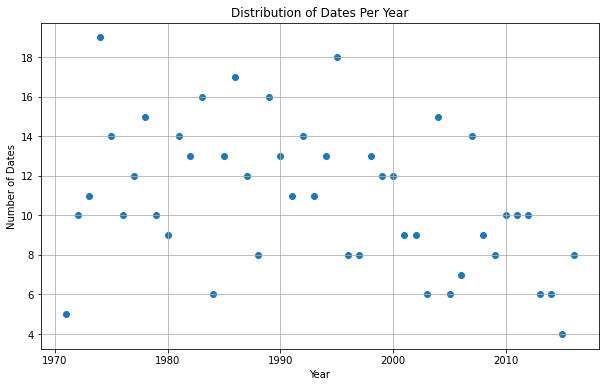

In [45]:
yearly_counts = dataframe.groupby('Year').size()
plt.figure(figsize=(10, 6))
plt.scatter(yearly_counts.index, yearly_counts.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Dates')
plt.title('Distribution of Dates Per Year')
plt.grid(True)
plt.show()